# T-Maze

Experiments with modifications to the t-maze enviroment.

see https://papers.nips.cc/paper/1953-reinforcement-learning-with-long-short-term-memory.pdf

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import sys

import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class TMaze:   
    
    def __init__(self, size=3, step_reward=0.0):
        self.size = size #takes size number of steps to reach decision node
        self.step_reward = step_reward
    
    def __str__(self):
        statement = "Position: {}, Size: {}, Goal: {} ".format(self.position, self.size, self.getGoal(self.goal)) 
        return statement
                
    def getGoal(self, num):
        if num == 1:
            return "E"
        else:
            return "W"
        
    def max_score(self):
        """ returns the maximum possiable score on this enviroment. """
        return 4.0 + self.step_reward * self.size
        
    def step(self, action):
        """
        action - [0,1,2,3]
        directions = ["N","S","E","W"]
        Returns observation and reward
        """
        dx,dy = self.getDis(action)
        
        reward = self.step_reward
        done = False
        
        self.position += dy
        
        #going beyond maze upwards
        if self.position > self.size:
            reward = -0.1
            self.position += -1
        #downwards
        elif self.position < 0:
            reward = -0.1
            self.position += 1
            
        #moving left or right    
        if dx != 0:
            if self.position == self.size:
                if dx == self.goal:
                    reward = 4
                else:
                    reward = -0.1
                self.reset()
                done = True
            else:
                reward = -0.1
        
        return self.getObs(self.position),reward, done    
            
        
    def getObs(self, position):
        if position == 0:
            return self.observations[0]
        elif position == self.size:
            return self.observations[2]
        else:
            return self.observations[1]
    
    def getDis(self, action):
        """
        returns dx and dy, that represent change in position 
        """
        dis = [(0,1), (0,-1), (1,0), (-1,0)]
        return dis[action]
    
    def getAction(self, action):
        """
        for abstraction
        """
        directions = ["N","S","E","W"]
        return directions[action]
    
    def reset(self):
        
        """ Resets and returns initial observation """
        self.position = 0
        goal = random.choice([1,-1])
        self.goal = goal # 1 = 'E' -1 = 'W'        
        #'110' is W ;011 is E, corridor, decision node
        if goal == 1:
            self.observations = [(0,1,1),(1,0,1), (0,1,0)]
        else:
            self.observations = [(1,1,0),(1,0,1), (0,1,0)]
        return self.getObs(0)
    

In [3]:
env = TMaze() #size 3
print(env.reset())

print(env)

print(env.step(1))
print(env.step(2))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(2))

(1, 1, 0)
Position: 0, Size: 3, Goal: W 
((1, 1, 0), -0.1, False)
((1, 1, 0), -0.1, False)
((1, 0, 1), 0.0, False)
((1, 0, 1), 0.0, False)
((0, 1, 0), 0.0, False)
((0, 1, 0), -0.1, False)
((1, 1, 0), -0.1, True)


In [4]:
print(env)

Position: 0, Size: 3, Goal: W 


In [5]:
class RandomAgent():
    
    def __init__(self):
        pass
    
    def act(self, obs,reward, done):
        return random.choice([0,1,2,3])

In [6]:
randAgent = RandomAgent()
env = TMaze()
obs = env.reset()

done = False
reward = 0
totalRewards = []
episodes = 100
totalSteps = []
for i in range(episodes):
    cumReward = 0
    for step in range(1000):
        action = randAgent.act(obs,reward, done)
        obs,reward,done = env.step(action)
        cumReward += reward

        if done:
            break
    totalSteps.append(step)
    totalRewards.append(cumReward)
    #print("CumReward: {}, Steps: {}, Episode: {} ".format(cumReward, step, i)) 


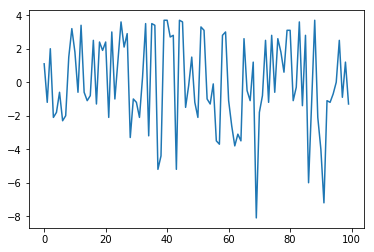

In [7]:
plt.plot(range(episodes), totalRewards)
plt.show()

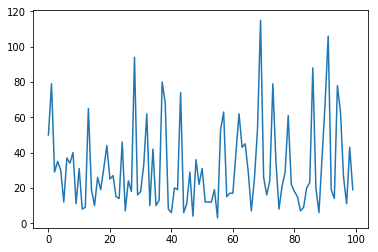

In [8]:
plt.plot(range(episodes), totalSteps)
plt.show()

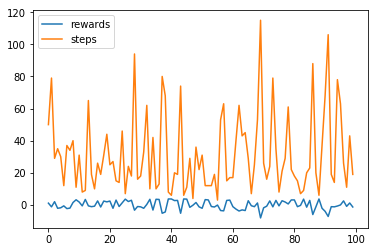

In [9]:
plt.plot(range(episodes), totalRewards, label = "rewards")
plt.plot(range(episodes), totalSteps, label = 'steps')
plt.legend()
plt.show()

# LSTM Agent as per 

https://arxiv.org/pdf/1507.06527.pdf
    

In [10]:
# Our Fast / Slow model
class LSTM_Agent(nn.Module):
    
    def __init__(self, input_dims = 3, hidden_dims = 12, memory_dims = 3, actions_dims = 4, learning_rate = 0.001, epsilon=0.1):
        
        super().__init__()
        
        self.memory_dims = memory_dims
        self.actions_dims = actions_dims
        
        self.hidden = nn.Linear(input_dims, hidden_dims)
        
        self.lstm = nn.LSTM(hidden_dims, memory_dims)
        
        self.q = nn.Linear(memory_dims, actions_dims)
                
        self.optimizer = optim.Adam(self.parameters(), learning_rate)
        
        self.epsilon = epsilon
        
        self.reset()
                
    def reset(self):
        # dims are sequence length, batch_size, number of units.
        self.h_state = torch.zeros(1, 1, self.memory_dims)
        self.c_state = torch.zeros(1, 1, self.memory_dims)
        
    def forward(self, x):
                
        h = F.relu(self.hidden(x))        
        # lstm expects dims 1,1,3 i.e. sequence_length, batch_size, memory units
        h = h.unsqueeze(0)
        memory_activations, (self.h_state, self.c_state) = self.lstm(h, (self.h_state, self.c_state))
        q_out = self.q(memory_activations)
        
        return q_out
    
    def act(self, observation, e_greedy=True):
        """ Returns an action based on current policy, and q values """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(range(self.actions_dims))), q
        else:
            # pick optimal            
            return int(np.argmax(q.detach())), q
        
class LSTM_Passthru_Agent(nn.Module):
 
    def __init__(self, input_dims = 3, hidden_dims = 12, memory_dims = 3, actions_dims = 4, learning_rate = 0.001, epsilon=0.1):
        
        super().__init__()
        
        self.memory_dims = memory_dims
        self.actions_dims = actions_dims
        
        self.hidden = nn.Linear(input_dims, hidden_dims)                
        self.lstm = nn.LSTM(hidden_dims, memory_dims)
        
        self.q = nn.Linear(memory_dims + hidden_dims, actions_dims)
                
        self.optimizer = optim.Adam(self.parameters(), learning_rate)
        
        self.epsilon = epsilon
        
        self.reset()
                
    def reset(self):
        # dims are sequence length, batch_size, number of units.
        self.h_state = torch.zeros(1, 1, self.memory_dims)
        self.c_state = torch.zeros(1, 1, self.memory_dims)
        
    def forward(self, x_in):
                            
        h = F.relu(self.hidden(x_in))        
        
        # lstm expects dims 1,1,3 i.e. sequence_length, batch_size, memory units
        memory_in = h.unsqueeze(0)        
        memory_activations, (self.h_state, self.c_state) = self.lstm(memory_in, (self.h_state, self.c_state))
        
        memory_activations = memory_activations.squeeze(0)        
        
        concat = torch.cat([memory_activations, h], dim=1)
        
        q_out = self.q(concat)
        
        return q_out
    
    def act(self, observation, e_greedy=True):
        """ Returns an action based on current policy, and q values """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(range(self.actions_dims))), q
        else:
            # pick optimal            
            return int(np.argmax(q.detach())), q
    

class LSTM_Smart_Agent(LSTM_Agent):
    
    """ This agent can only perform 'valid' actions, which simplifies the learning task to just
        remembering the initial pattern.
    """
    
    def __init__(self, can_go_north_at_end=False, **kwargs):
        super().__init__(**kwargs)
        self.can_go_north_at_end = can_go_north_at_end
    
    
    def act(self, observation, e_greedy=True):
        """ Returns action based on current policy and q values, but
            excludes invalid actions.
        """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        
        if np.array_equal(np.array(observation[0]), np.array([0,1,0])):
            valid_actions = [0,2,3] if self.can_go_north_at_end else [2,3]
        else:
            valid_actions = [0]
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(valid_actions)), q
        else:
            # pick optimal            
            q_values_for_valid_actions = [q.detach()[action] for action in valid_actions]
            optimal_valid_action = np.argmax(q_values_for_valid_actions)
            return valid_actions[optimal_valid_action], q

    

In [11]:
# Hyper Parameters

GAMMA = 0.98
EPSILON = 0.10
LEARNING_RATE = 0.0003

PRINT_EVERY = 1000

In [12]:
def eval_agent(agent, env, trials=100, verbose=False, use_egreedy=False):
    """ Evaulates agent by running it greed through a number of trials.
        Returns average reward.
    """
        
    observation = env.reset()

    done = False
    reward = 0
    totalRewards = []
    totalSteps = []

    for i in range(trials):    
        cumReward = 0

        # clear agents memory
        agent.reset()

        observation = env.reset()

        # get first action for agent
        action, q_values = agent.act(observation, e_greedy=use_egreedy)    

        max_steps = 250

        agent.optimizer.zero_grad()

        for step in range(max_steps):

            # get next action and state

            next_observation, reward, done = env.step(action)
            next_action, next_q_values = agent.act(next_observation, e_greedy=use_egreedy)            

            # ------------------------------
            # calculate DQN Loss        

            # v is the estimated value of the next state 
            v = torch.max(next_q_values)

            # q is the estimated value of the current state / action pair
            q = q_values[action]  
            
            if verbose:
                print("step: {} action: {} q: {}, obs: {}, pos: {} ".format(step,next_action, np.array(next_q_values.detach()), next_observation, env.position))
            
            # keep track of everything
            cumReward += reward

            observation = next_observation
            action = next_action
            q_values = next_q_values        

            if done:
                break            

        totalSteps.append(step)
        totalRewards.append(cumReward)
        
    return np.mean(totalRewards)

def run_test(depth, agent, verbose=False, stepReward=0.0):

    global totalRewards
    global totalSteps
    global scoreHistory
            
    env = TMaze(depth, step_reward=stepReward)

    observation = env.reset()

    done = False
    reward = 0
    totalRewards = []
    totalSteps = []
    scoreHistory = []
    episodes = 10000000
    
    did_reach_optimal = -1
    
    for i in range(episodes):    
        cumReward = 0

        # clear agents memory
        agent.reset()

        observation = env.reset()

        # get first action for agent
        action, q_values = agent.act(observation)    

        max_steps = 250
        
        if did_reach_optimal >= 0 and i >= did_reach_optimal + 5000:
            return did_reach_optimal
            

        if i % 10000 == 0 and i != 0:
            print(".",end='')
            sys.stdout.flush() # makes the prints happen immediately
            
        if i % PRINT_EVERY == 0 and i != 0:
            
            av_reward = np.mean(totalRewards[-1000:])
            score = eval_agent(agent, env)
            
            if verbose:
                print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f} score:{:.3f}".format(
                    i, 
                    av_reward,
                    np.mean(totalSteps[-1000:]),
                    EPSILON,
                    score))
                
            scoreHistory.append((i, score))
            
            if did_reach_optimal == -1 and score >= env.max_score() * 0.95:
                # we give the agent a little grace,
                # also, eval turns off e-greedy.
                # as far as I can tell the agent should converge to 4.0
                did_reach_optimal = i

        loss = 0

        agent.optimizer.zero_grad()

        for step in range(max_steps):

            # get next action and state

            next_observation, reward, done = env.step(action)
            next_action, next_q_values = agent.act(next_observation)            

            # ------------------------------
            # calculate DQN Loss        

            # v is the estimated value of the next state 
            v = torch.max(next_q_values)

            # q is the estimated value of the current state / action pair
            q = q_values[action]  
            loss += (reward + GAMMA * v - q)**2     

            # keep track of everything
            cumReward += reward

            observation = next_observation
            action = next_action
            q_values = next_q_values        

            if done:
                break            

        # apply update
        loss.backward()
        agent.optimizer.step()

        #EPSILON = EPSILON * (1-1/1000)

        totalSteps.append(step)
        totalRewards.append(cumReward)
    
    print("Did not converge.")
    
    print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f}".format(
                    i, 
                    np.mean(totalRewards[-1000:]),
                    np.mean(totalSteps[-1000:]),
                    EPSILON
    ))
    return -1
    

In [13]:
# results:
#                  0    5  10  15   20  25  30  35  40  45  50  55
# original:        11, 20, 24, 15, 153, 65, 93, 67, 36, 97, 94, 68
# smart, no north: 11, 18, 12, 14                           29
# smart, go north:  5, 17, 14, 7, 7

# changed enviroment to -0.01 step reward

# passthru, with hidden before memory
#                  1,  15, 100+
# original:        4,  13, 43+

# changed enviroment to 0.0 step reward

# original:        11, 32,


#results = []
    
#for depth in range(0,6,5):
#    agent = LSTM_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
#    steps = run_test(depth, agent=agent, verbose=True)//1000
#    print("\n{}: {}K".format(depth, steps))
#    plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.9), alpha=0.3, label = "rewards")
#    plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.99), label = "rewards")
#    plt.plot([x for (x,y) in scoreHistory], [y for (x,y) in scoreHistory], label = "score")
#    plt.legend()
#    plt.show()

#    results.append((depth, steps))

In [24]:
import csv
import os

def generateResults(depthStart=0, depthEnd=5, originalAgent = True, step_reward=0.0):
    """
    prints results/graphs and stores results in csv
    Eg : depthStart = 0, depthEnd = 10, gives results for TMaze of depth 0, depth 5 and depth 10
    step_reward -> what step reward to give in the TMaze environment 
    
    CSV Files - Organised into directories Agent_NegReward\depth_i\file 
    file is of three types - rewards.csv, results.csv, scores.csv
    Agent - Original or passthru
    NegReward - negative step reward or 0 step reward
    depth_i where i is the depth number of the TMaze
    """
    results = []
    
    if (originalAgent) :
        agent = LSTM_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    else:
        agent = LSTM_Passthru_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    
    for depth in range(depthStart,depthEnd+1,5):

            
        steps = run_test(depth, agent=agent, verbose=True, stepReward=step_reward)//1000
        print("\n{}: {}K".format(depth, steps))
        plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.9), alpha=0.3, label = "rewards")
        plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.99), label = "rewards")
        plt.plot([x for (x,y) in scoreHistory], [y for (x,y) in scoreHistory], label = "score")
        plt.legend()
        plt.show()

        results.append((depth, steps))
        
        directory = "continual/original_" if originalAgent else "continual/passThru_"
        dir2 = 'negReward/' if step_reward < 0 else '0stepReward/'
        directory = directory + dir2
        subDirectory = "depth_" + str(depth) + "/"
        
        dirName = directory + subDirectory
        
        if not os.path.exists(dirName):
            os.makedirs(dirName)
        
        rewardsFile = dirName + "rewards.csv" 
        scoreFile = dirName + "score.csv"
        resultsFile = dirName + "results.csv"
        
        with open(rewardsFile, 'w') as reward, open(scoreFile, 'w') as score, open(resultsFile, 'w') as result:
            
            writer1 = csv.writer(reward)
            writer2 = csv.writer(score)
            writer3 = csv.writer(result)
            
            head1 = ['episode','reward']
            head2 = ['episode','score']
            head3 = ['depth','steps']
            
            writer1.writerow(head1)
            writer2.writerow(head2)
            writer3.writerow(head3)
            
            for i in range(len(totalRewards[500:])):
                row = [i,totalRewards[i]]
                writer1.writerow(row)
            for (x,y) in scoreHistory:
                row = [x,y]
                writer2.writerow(row)
                
            writer3.writerow([depth,steps])

        


Episode: 1000, Recent reward average: 2.02 steps average: 0.05, eps:0.100 score:2.278
Episode: 2000, Recent reward average: 2.02 steps average: 0.30, eps:0.100 score:2.155
Episode: 3000, Recent reward average: 1.85 steps average: 0.55, eps:0.100 score:1.950
Episode: 4000, Recent reward average: 2.00 steps average: 0.49, eps:0.100 score:1.827
Episode: 5000, Recent reward average: 1.93 steps average: 0.66, eps:0.100 score:1.827
Episode: 6000, Recent reward average: 1.85 steps average: 1.05, eps:0.100 score:2.032
Episode: 7000, Recent reward average: 1.92 steps average: 0.58, eps:0.100 score:1.540
Episode: 8000, Recent reward average: 1.86 steps average: 0.54, eps:0.100 score:1.704
Episode: 9000, Recent reward average: 2.03 steps average: 0.14, eps:0.100 score:1.868
.Episode: 10000, Recent reward average: 2.36 steps average: 0.06, eps:0.100 score:4.000
Episode: 11000, Recent reward average: 3.36 steps average: 0.07, eps:0.100 score:4.000
Episode: 12000, Recent reward average: 3.93 steps a

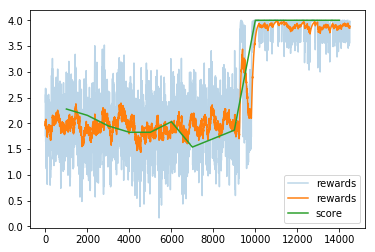

Episode: 1000, Recent reward average: -15.21 steps average: 201.97, eps:0.100 score:-25.000
Episode: 2000, Recent reward average: -12.61 steps average: 145.18, eps:0.100 score:-13.432
Episode: 3000, Recent reward average: -6.41 steps average: 87.70, eps:0.100 score:-25.000
Episode: 4000, Recent reward average: -8.61 steps average: 234.24, eps:0.100 score:-13.344
Episode: 5000, Recent reward average: -10.94 steps average: 247.27, eps:0.100 score:-14.584
Episode: 6000, Recent reward average: -11.02 steps average: 249.00, eps:0.100 score:-13.144
Episode: 7000, Recent reward average: -14.34 steps average: 246.31, eps:0.100 score:1.891
Episode: 8000, Recent reward average: -2.94 steps average: 117.13, eps:0.100 score:2.073
Episode: 9000, Recent reward average: 1.03 steps average: 16.24, eps:0.100 score:1.663
.Episode: 10000, Recent reward average: 1.17 steps average: 12.36, eps:0.100 score:1.868
Episode: 11000, Recent reward average: 1.28 steps average: 12.12, eps:0.100 score:2.032
Episode:

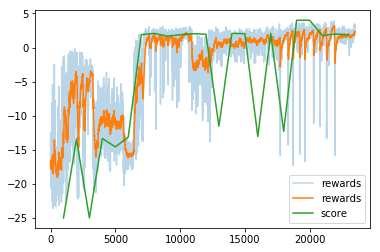

Episode: 1000, Recent reward average: 1.00 steps average: 25.04, eps:0.100 score:1.678
Episode: 2000, Recent reward average: 1.99 steps average: 16.59, eps:0.100 score:4.000
Episode: 3000, Recent reward average: 1.33 steps average: 19.69, eps:0.100 score:2.020
Episode: 4000, Recent reward average: 1.85 steps average: 14.02, eps:0.100 score:3.956
Episode: 5000, Recent reward average: 2.50 steps average: 20.33, eps:0.100 score:3.592
Episode: 6000, Recent reward average: 2.42 steps average: 21.15, eps:0.100 score:3.953

10: 2K


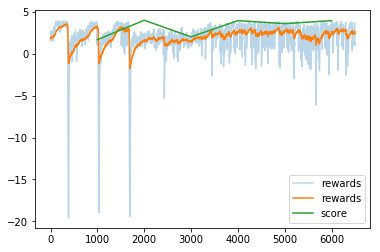

Episode: 1000, Recent reward average: 1.90 steps average: 25.97, eps:0.100 score:4.000
Episode: 2000, Recent reward average: 1.87 steps average: 29.55, eps:0.100 score:3.950
Episode: 3000, Recent reward average: 2.10 steps average: 29.21, eps:0.100 score:4.000
Episode: 4000, Recent reward average: 2.20 steps average: 27.52, eps:0.100 score:4.000
Episode: 5000, Recent reward average: 2.10 steps average: 22.20, eps:0.100 score:1.786

15: 1K


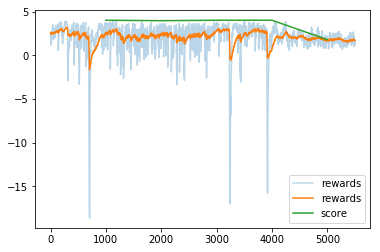

Episode: 1000, Recent reward average: 1.21 steps average: 28.42, eps:0.100 score:1.991
Episode: 2000, Recent reward average: 1.43 steps average: 26.12, eps:0.100 score:1.820
Episode: 3000, Recent reward average: 1.56 steps average: 25.91, eps:0.100 score:1.900
Episode: 4000, Recent reward average: 1.60 steps average: 24.59, eps:0.100 score:1.868
Episode: 5000, Recent reward average: 1.64 steps average: 24.29, eps:0.100 score:1.991
Episode: 6000, Recent reward average: 1.43 steps average: 26.07, eps:0.100 score:2.020
Episode: 7000, Recent reward average: 1.48 steps average: 25.16, eps:0.100 score:1.704
Episode: 8000, Recent reward average: 1.33 steps average: 27.16, eps:0.100 score:2.032
Episode: 9000, Recent reward average: 1.03 steps average: 29.45, eps:0.100 score:2.155
.Episode: 10000, Recent reward average: 0.91 steps average: 30.76, eps:0.100 score:1.950
Episode: 11000, Recent reward average: 1.12 steps average: 30.10, eps:0.100 score:1.909
Episode: 12000, Recent reward average: 1

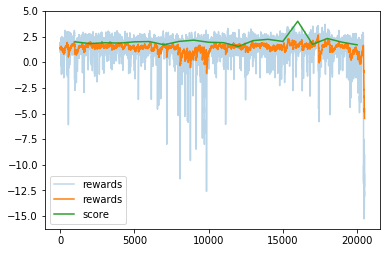

Episode: 1000, Recent reward average: -14.19 steps average: 177.86, eps:0.100 score:-9.630
Episode: 2000, Recent reward average: -3.74 steps average: 79.13, eps:0.100 score:2.278
Episode: 3000, Recent reward average: 0.52 steps average: 40.41, eps:0.100 score:1.991
Episode: 4000, Recent reward average: 0.21 steps average: 43.48, eps:0.100 score:-9.096
Episode: 5000, Recent reward average: -12.54 steps average: 159.29, eps:0.100 score:2.483
Episode: 6000, Recent reward average: 1.64 steps average: 29.52, eps:0.100 score:1.909
Episode: 7000, Recent reward average: -1.09 steps average: 56.53, eps:0.100 score:-13.996
Episode: 8000, Recent reward average: -5.58 steps average: 95.56, eps:0.100 score:1.827
Episode: 9000, Recent reward average: -0.76 steps average: 52.34, eps:0.100 score:1.950
.Episode: 10000, Recent reward average: -4.77 steps average: 90.39, eps:0.100 score:2.237
Episode: 11000, Recent reward average: 1.69 steps average: 27.83, eps:0.100 score:1.991
Episode: 12000, Recent re

Episode: 94000, Recent reward average: -5.09 steps average: 117.14, eps:0.100 score:-12.052
Episode: 95000, Recent reward average: -1.93 steps average: 68.07, eps:0.100 score:1.827
Episode: 96000, Recent reward average: 1.85 steps average: 27.74, eps:0.100 score:1.868
Episode: 97000, Recent reward average: 1.83 steps average: 27.80, eps:0.100 score:1.581
Episode: 98000, Recent reward average: 1.89 steps average: 27.81, eps:0.100 score:1.909
Episode: 99000, Recent reward average: 1.79 steps average: 27.83, eps:0.100 score:1.704
.Episode: 100000, Recent reward average: 1.83 steps average: 28.03, eps:0.100 score:1.745
Episode: 101000, Recent reward average: 0.50 steps average: 44.25, eps:0.100 score:1.991
Episode: 102000, Recent reward average: -6.61 steps average: 123.63, eps:0.100 score:-12.550
Episode: 103000, Recent reward average: 1.25 steps average: 31.27, eps:0.100 score:1.745
Episode: 104000, Recent reward average: 1.85 steps average: 28.00, eps:0.100 score:1.622
Episode: 105000, 

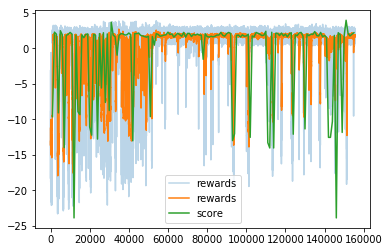

Episode: 1000, Recent reward average: 1.70 steps average: 34.23, eps:0.100 score:1.581
Episode: 2000, Recent reward average: 1.77 steps average: 34.50, eps:0.100 score:1.991
Episode: 3000, Recent reward average: 1.95 steps average: 33.36, eps:0.100 score:1.786
Episode: 4000, Recent reward average: 0.30 steps average: 51.35, eps:0.100 score:-13.048
Episode: 5000, Recent reward average: 0.84 steps average: 56.45, eps:0.100 score:2.060
Episode: 6000, Recent reward average: 0.95 steps average: 55.20, eps:0.100 score:3.432
Episode: 7000, Recent reward average: 1.49 steps average: 49.48, eps:0.100 score:1.900
Episode: 8000, Recent reward average: 1.39 steps average: 50.48, eps:0.100 score:1.827
Episode: 9000, Recent reward average: 1.85 steps average: 46.19, eps:0.100 score:1.909
.Episode: 10000, Recent reward average: 2.15 steps average: 42.81, eps:0.100 score:4.000
Episode: 11000, Recent reward average: 2.77 steps average: 38.40, eps:0.100 score:4.000
Episode: 12000, Recent reward average:

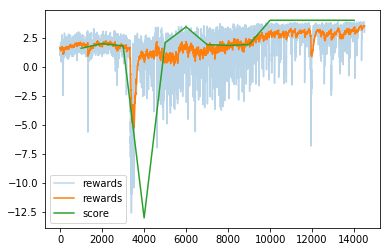

Episode: 1000, Recent reward average: 3.43 steps average: 39.84, eps:0.100 score:4.000
Episode: 2000, Recent reward average: 3.50 steps average: 39.33, eps:0.100 score:4.000
Episode: 3000, Recent reward average: 3.54 steps average: 39.19, eps:0.100 score:3.947
Episode: 4000, Recent reward average: 3.48 steps average: 39.43, eps:0.100 score:1.868
Episode: 5000, Recent reward average: -10.21 steps average: 238.46, eps:0.100 score:-4.769

35: 1K


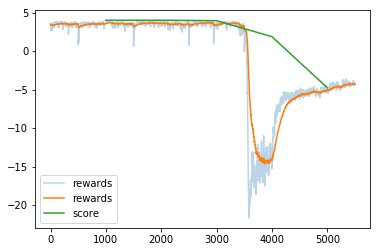

Episode: 1000, Recent reward average: -3.48 steps average: 249.00, eps:0.100 score:-0.408
Episode: 2000, Recent reward average: 1.01 steps average: 68.58, eps:0.100 score:1.320
Episode: 3000, Recent reward average: 1.35 steps average: 49.77, eps:0.100 score:1.674
Episode: 4000, Recent reward average: 1.51 steps average: 47.32, eps:0.100 score:1.590
Episode: 5000, Recent reward average: 1.31 steps average: 48.53, eps:0.100 score:1.481
Episode: 6000, Recent reward average: 1.43 steps average: 48.37, eps:0.100 score:1.842
Episode: 7000, Recent reward average: 1.32 steps average: 48.44, eps:0.100 score:1.144
Episode: 8000, Recent reward average: 1.22 steps average: 49.29, eps:0.100 score:1.144
Episode: 9000, Recent reward average: 1.23 steps average: 49.64, eps:0.100 score:0.362
.Episode: 10000, Recent reward average: 0.97 steps average: 51.65, eps:0.100 score:-0.820
Episode: 11000, Recent reward average: 1.02 steps average: 51.96, eps:0.100 score:-0.132
Episode: 12000, Recent reward avera

Episode: 93000, Recent reward average: 0.90 steps average: 56.42, eps:0.100 score:2.032
Episode: 94000, Recent reward average: 1.28 steps average: 51.41, eps:0.100 score:2.155
Episode: 95000, Recent reward average: 1.30 steps average: 49.89, eps:0.100 score:1.499
Episode: 96000, Recent reward average: 1.06 steps average: 53.40, eps:0.100 score:1.581
Episode: 97000, Recent reward average: 1.19 steps average: 49.19, eps:0.100 score:2.032
Episode: 98000, Recent reward average: 1.12 steps average: 53.82, eps:0.100 score:1.991
Episode: 99000, Recent reward average: 0.86 steps average: 55.00, eps:0.100 score:1.745
.Episode: 100000, Recent reward average: 1.43 steps average: 46.90, eps:0.100 score:-25.000
Episode: 101000, Recent reward average: 1.06 steps average: 52.45, eps:0.100 score:1.499
Episode: 102000, Recent reward average: 0.98 steps average: 53.43, eps:0.100 score:2.032
Episode: 103000, Recent reward average: 1.62 steps average: 46.67, eps:0.100 score:2.196
Episode: 104000, Recent r

Episode: 185000, Recent reward average: 1.12 steps average: 54.08, eps:0.100 score:1.909
Episode: 186000, Recent reward average: 1.04 steps average: 51.60, eps:0.100 score:-12.240
Episode: 187000, Recent reward average: 1.15 steps average: 54.09, eps:0.100 score:1.909
Episode: 188000, Recent reward average: 1.20 steps average: 51.42, eps:0.100 score:1.704
Episode: 189000, Recent reward average: 1.22 steps average: 54.71, eps:0.100 score:2.237
.Episode: 190000, Recent reward average: 1.10 steps average: 51.54, eps:0.100 score:1.827
Episode: 191000, Recent reward average: 0.98 steps average: 54.20, eps:0.100 score:-12.240
Episode: 192000, Recent reward average: 1.03 steps average: 53.07, eps:0.100 score:1.780
Episode: 193000, Recent reward average: 1.00 steps average: 56.23, eps:0.100 score:2.032
Episode: 194000, Recent reward average: -0.41 steps average: 69.10, eps:0.100 score:1.745
Episode: 195000, Recent reward average: 0.54 steps average: 60.66, eps:0.100 score:1.704
Episode: 196000

Episode: 277000, Recent reward average: 1.20 steps average: 50.06, eps:0.100 score:1.950
Episode: 278000, Recent reward average: 1.62 steps average: 45.12, eps:0.100 score:1.417
Episode: 279000, Recent reward average: 1.44 steps average: 49.23, eps:0.100 score:1.786
.Episode: 280000, Recent reward average: 0.83 steps average: 55.83, eps:0.100 score:1.909
Episode: 281000, Recent reward average: 1.11 steps average: 53.34, eps:0.100 score:1.950
Episode: 282000, Recent reward average: 0.61 steps average: 58.53, eps:0.100 score:1.991
Episode: 283000, Recent reward average: 1.75 steps average: 44.56, eps:0.100 score:2.114
Episode: 284000, Recent reward average: 0.34 steps average: 60.41, eps:0.100 score:2.237
Episode: 285000, Recent reward average: 1.79 steps average: 44.51, eps:0.100 score:1.868
Episode: 286000, Recent reward average: 1.71 steps average: 44.38, eps:0.100 score:1.950
Episode: 287000, Recent reward average: 1.66 steps average: 45.04, eps:0.100 score:1.581
Episode: 288000, Rec

KeyboardInterrupt: 

In [25]:
generateResults(0,70)

Episode: 1000, Recent reward average: 1.22 steps average: 7.12, eps:0.100 score:1.370
Episode: 2000, Recent reward average: 2.05 steps average: 1.86, eps:0.100 score:3.896
Episode: 3000, Recent reward average: 3.62 steps average: 1.36, eps:0.100 score:4.000
Episode: 4000, Recent reward average: 3.89 steps average: 0.04, eps:0.100 score:4.000
Episode: 5000, Recent reward average: 3.87 steps average: 0.09, eps:0.100 score:4.000
Episode: 6000, Recent reward average: 3.88 steps average: 0.09, eps:0.100 score:4.000

0: 2K


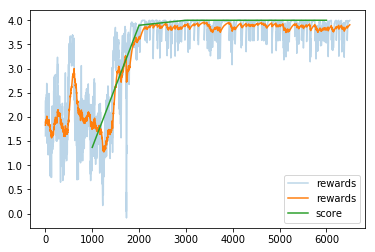

Episode: 1000, Recent reward average: -6.69 steps average: 89.96, eps:0.100 score:-25.000


KeyboardInterrupt: 

In [28]:
generateResults(0,70, step_reward=-0.01)

Episode: 1000, Recent reward average: 1.06 steps average: 5.92, eps:0.100 score:2.073
Episode: 2000, Recent reward average: 1.89 steps average: 0.07, eps:0.100 score:1.786
Episode: 3000, Recent reward average: 1.85 steps average: 0.10, eps:0.100 score:1.622
Episode: 4000, Recent reward average: 1.74 steps average: 0.05, eps:0.100 score:1.909
Episode: 5000, Recent reward average: 2.00 steps average: 0.06, eps:0.100 score:1.991
Episode: 6000, Recent reward average: 1.91 steps average: 0.04, eps:0.100 score:1.745
Episode: 7000, Recent reward average: 1.91 steps average: 0.06, eps:0.100 score:2.114
Episode: 8000, Recent reward average: 2.12 steps average: 0.05, eps:0.100 score:1.991
Episode: 9000, Recent reward average: 2.16 steps average: 0.05, eps:0.100 score:1.868
.Episode: 10000, Recent reward average: 2.52 steps average: 0.04, eps:0.100 score:4.000
Episode: 11000, Recent reward average: 3.63 steps average: 0.06, eps:0.100 score:4.000
Episode: 12000, Recent reward average: 3.89 steps a

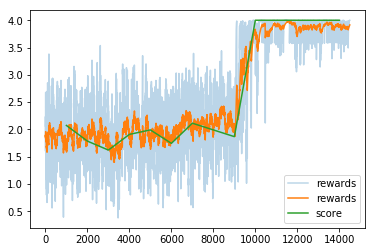

Episode: 1000, Recent reward average: -3.52 steps average: 93.07, eps:0.100 score:-25.000
Episode: 2000, Recent reward average: -0.93 steps average: 36.53, eps:0.100 score:-9.448
Episode: 3000, Recent reward average: -0.18 steps average: 25.73, eps:0.100 score:-11.706
Episode: 4000, Recent reward average: -0.23 steps average: 26.32, eps:0.100 score:-13.151
Episode: 5000, Recent reward average: 0.12 steps average: 24.07, eps:0.100 score:-11.706
Episode: 6000, Recent reward average: 0.01 steps average: 25.18, eps:0.100 score:-7.949
Episode: 7000, Recent reward average: 0.16 steps average: 24.25, eps:0.100 score:-13.151
Episode: 8000, Recent reward average: 0.38 steps average: 20.97, eps:0.100 score:0.911
Episode: 9000, Recent reward average: 1.58 steps average: 9.99, eps:0.100 score:1.879
.Episode: 10000, Recent reward average: 1.49 steps average: 9.71, eps:0.100 score:1.415
Episode: 11000, Recent reward average: 1.68 steps average: 8.62, eps:0.100 score:1.791
Episode: 12000, Recent rewa

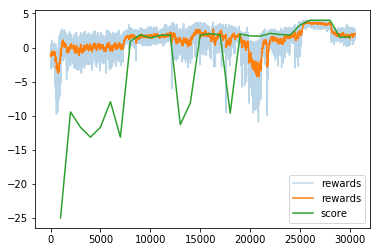

Episode: 1000, Recent reward average: 1.41 steps average: 56.42, eps:0.100 score:1.756
Episode: 2000, Recent reward average: 1.30 steps average: 41.81, eps:0.100 score:1.936
Episode: 3000, Recent reward average: 1.17 steps average: 55.30, eps:0.100 score:1.700
Episode: 4000, Recent reward average: 0.82 steps average: 63.29, eps:0.100 score:1.800
Episode: 5000, Recent reward average: 1.14 steps average: 63.59, eps:0.100 score:2.064
Episode: 6000, Recent reward average: 0.88 steps average: 100.66, eps:0.100 score:1.480
Episode: 7000, Recent reward average: 0.99 steps average: 75.48, eps:0.100 score:1.900
Episode: 8000, Recent reward average: 1.34 steps average: 93.80, eps:0.100 score:1.950
Episode: 9000, Recent reward average: 1.10 steps average: 123.30, eps:0.100 score:1.786
.Episode: 10000, Recent reward average: 1.02 steps average: 129.70, eps:0.100 score:2.073
Episode: 11000, Recent reward average: 1.17 steps average: 125.54, eps:0.100 score:1.909
Episode: 12000, Recent reward averag

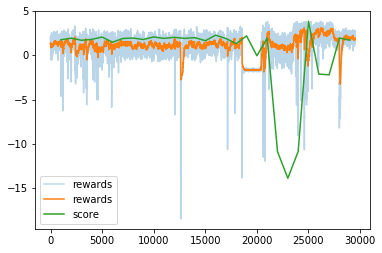

Episode: 1000, Recent reward average: 1.46 steps average: 31.98, eps:0.100 score:2.073
Episode: 2000, Recent reward average: 1.73 steps average: 25.78, eps:0.100 score:1.820
Episode: 3000, Recent reward average: 1.68 steps average: 29.45, eps:0.100 score:1.745
Episode: 4000, Recent reward average: 1.76 steps average: 25.32, eps:0.100 score:2.260
Episode: 5000, Recent reward average: 1.71 steps average: 26.56, eps:0.100 score:1.358
Episode: 6000, Recent reward average: 1.78 steps average: 24.95, eps:0.100 score:1.686
Episode: 7000, Recent reward average: 1.77 steps average: 27.98, eps:0.100 score:-0.100
Episode: 8000, Recent reward average: 1.76 steps average: 28.85, eps:0.100 score:2.060
Episode: 9000, Recent reward average: 1.66 steps average: 32.99, eps:0.100 score:1.980
.Episode: 10000, Recent reward average: 1.60 steps average: 21.29, eps:0.100 score:1.991
Episode: 11000, Recent reward average: 1.76 steps average: 28.80, eps:0.100 score:2.240
Episode: 12000, Recent reward average: 

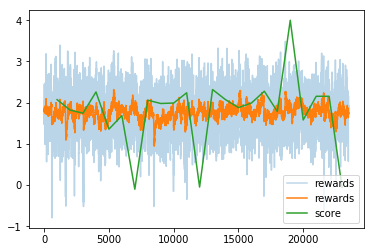

Episode: 1000, Recent reward average: 1.73 steps average: 25.08, eps:0.100 score:1.745
Episode: 2000, Recent reward average: 1.79 steps average: 26.02, eps:0.100 score:2.032
Episode: 3000, Recent reward average: 1.89 steps average: 23.39, eps:0.100 score:1.774
Episode: 4000, Recent reward average: 1.77 steps average: 24.08, eps:0.100 score:1.663
Episode: 5000, Recent reward average: 1.72 steps average: 24.24, eps:0.100 score:1.704
Episode: 6000, Recent reward average: 1.81 steps average: 24.01, eps:0.100 score:2.032
Episode: 7000, Recent reward average: 1.80 steps average: 23.27, eps:0.100 score:2.073
Episode: 8000, Recent reward average: 1.79 steps average: 23.27, eps:0.100 score:1.827
Episode: 9000, Recent reward average: 1.78 steps average: 24.34, eps:0.100 score:1.660
.Episode: 10000, Recent reward average: 1.75 steps average: 22.92, eps:0.100 score:1.991
Episode: 11000, Recent reward average: 1.77 steps average: 22.97, eps:0.100 score:1.827
Episode: 12000, Recent reward average: 1

Episode: 95000, Recent reward average: 1.73 steps average: 31.15, eps:0.100 score:2.196
Episode: 96000, Recent reward average: 1.46 steps average: 48.76, eps:0.100 score:1.663
Episode: 97000, Recent reward average: 1.90 steps average: 28.74, eps:0.100 score:1.991
Episode: 98000, Recent reward average: 1.42 steps average: 49.10, eps:0.100 score:2.155
Episode: 99000, Recent reward average: 1.68 steps average: 33.17, eps:0.100 score:1.950
.Episode: 100000, Recent reward average: 1.34 steps average: 50.25, eps:0.100 score:2.032
Episode: 101000, Recent reward average: 1.73 steps average: 23.96, eps:0.100 score:2.032
Episode: 102000, Recent reward average: 1.97 steps average: 22.99, eps:0.100 score:1.745
Episode: 103000, Recent reward average: 1.99 steps average: 23.11, eps:0.100 score:1.991
Episode: 104000, Recent reward average: 2.08 steps average: 26.34, eps:0.100 score:3.826
Episode: 105000, Recent reward average: 1.45 steps average: 63.91, eps:0.100 score:-0.048
Episode: 106000, Recent 

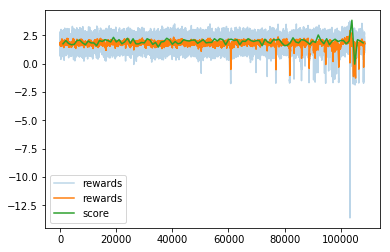

Episode: 1000, Recent reward average: 1.49 steps average: 46.85, eps:0.100 score:1.809
Episode: 2000, Recent reward average: 1.92 steps average: 28.85, eps:0.100 score:1.868
Episode: 3000, Recent reward average: 2.14 steps average: 31.18, eps:0.100 score:2.319
Episode: 4000, Recent reward average: 0.30 steps average: 124.50, eps:0.100 score:2.073
Episode: 5000, Recent reward average: 1.26 steps average: 64.05, eps:0.100 score:1.909
Episode: 6000, Recent reward average: 1.85 steps average: 29.40, eps:0.100 score:2.032
Episode: 7000, Recent reward average: 1.04 steps average: 30.21, eps:0.100 score:-0.100
Episode: 8000, Recent reward average: -3.92 steps average: 83.31, eps:0.100 score:-16.740
Episode: 9000, Recent reward average: -0.10 steps average: 45.99, eps:0.100 score:-11.305
.Episode: 10000, Recent reward average: 0.31 steps average: 40.77, eps:0.100 score:1.984
Episode: 11000, Recent reward average: 1.53 steps average: 28.05, eps:0.100 score:-0.100
Episode: 12000, Recent reward a

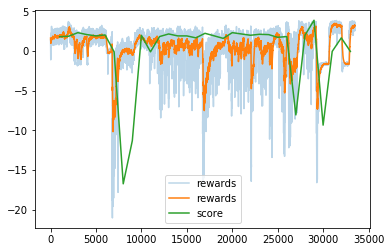

Episode: 1000, Recent reward average: 2.21 steps average: 34.16, eps:0.100 score:2.032
Episode: 2000, Recent reward average: 1.91 steps average: 34.83, eps:0.100 score:4.000
Episode: 3000, Recent reward average: 1.78 steps average: 35.57, eps:0.100 score:1.868
Episode: 4000, Recent reward average: 1.71 steps average: 34.08, eps:0.100 score:1.622
Episode: 5000, Recent reward average: 0.47 steps average: 47.52, eps:0.100 score:2.237
Episode: 6000, Recent reward average: 1.76 steps average: 36.43, eps:0.100 score:2.114

30: 2K


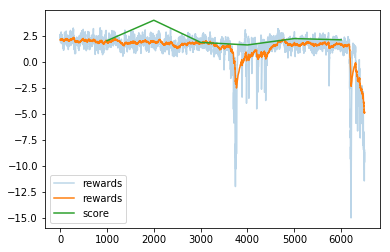

Episode: 1000, Recent reward average: 0.49 steps average: 51.77, eps:0.100 score:1.940
Episode: 2000, Recent reward average: 1.70 steps average: 39.23, eps:0.100 score:2.319
Episode: 3000, Recent reward average: 1.27 steps average: 46.24, eps:0.100 score:1.704
Episode: 4000, Recent reward average: 1.62 steps average: 50.54, eps:0.100 score:2.014
Episode: 5000, Recent reward average: 1.39 steps average: 53.64, eps:0.100 score:2.020
Episode: 6000, Recent reward average: 1.47 steps average: 54.05, eps:0.100 score:2.196
Episode: 7000, Recent reward average: 1.53 steps average: 48.38, eps:0.100 score:2.073
Episode: 8000, Recent reward average: 1.51 steps average: 49.06, eps:0.100 score:2.032
Episode: 9000, Recent reward average: 1.63 steps average: 42.84, eps:0.100 score:1.622
.Episode: 10000, Recent reward average: 1.67 steps average: 41.27, eps:0.100 score:2.155
Episode: 11000, Recent reward average: 1.72 steps average: 40.67, eps:0.100 score:1.991
Episode: 12000, Recent reward average: 1

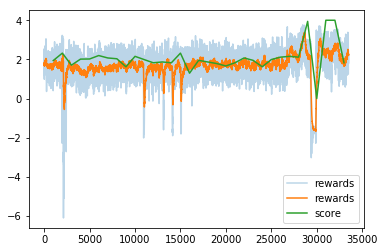

Episode: 1000, Recent reward average: 2.20 steps average: 46.23, eps:0.100 score:2.196
Episode: 2000, Recent reward average: 1.89 steps average: 45.61, eps:0.100 score:1.663
Episode: 3000, Recent reward average: 2.06 steps average: 44.95, eps:0.100 score:2.155
Episode: 4000, Recent reward average: 2.55 steps average: 45.27, eps:0.100 score:4.000
Episode: 5000, Recent reward average: 2.46 steps average: 45.65, eps:0.100 score:1.786
Episode: 6000, Recent reward average: 1.86 steps average: 46.44, eps:0.100 score:1.991
Episode: 7000, Recent reward average: 2.15 steps average: 45.96, eps:0.100 score:4.000
Episode: 8000, Recent reward average: 2.46 steps average: 45.30, eps:0.100 score:4.000

40: 4K


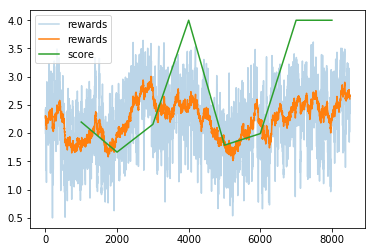

Episode: 1000, Recent reward average: 1.73 steps average: 51.83, eps:0.100 score:2.073
Episode: 2000, Recent reward average: 2.22 steps average: 51.43, eps:0.100 score:4.000
Episode: 3000, Recent reward average: 1.93 steps average: 51.56, eps:0.100 score:2.032
Episode: 4000, Recent reward average: 1.74 steps average: 52.45, eps:0.100 score:1.786
Episode: 5000, Recent reward average: 1.67 steps average: 52.01, eps:0.100 score:1.868
Episode: 6000, Recent reward average: 1.79 steps average: 50.81, eps:0.100 score:1.827

45: 2K


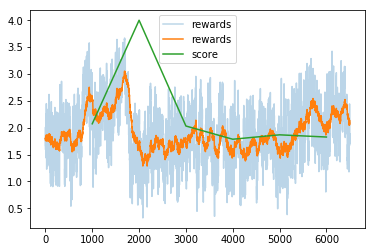

Episode: 1000, Recent reward average: 1.81 steps average: 56.79, eps:0.100 score:1.950
Episode: 2000, Recent reward average: 1.76 steps average: 57.94, eps:0.100 score:1.909
Episode: 3000, Recent reward average: 2.11 steps average: 56.83, eps:0.100 score:2.278
Episode: 4000, Recent reward average: 2.09 steps average: 56.29, eps:0.100 score:1.745
Episode: 5000, Recent reward average: 2.17 steps average: 56.94, eps:0.100 score:1.786
Episode: 6000, Recent reward average: 0.49 steps average: 123.35, eps:0.100 score:1.868
Episode: 7000, Recent reward average: 1.95 steps average: 56.20, eps:0.100 score:1.786
Episode: 8000, Recent reward average: 1.67 steps average: 55.88, eps:0.100 score:0.000
Episode: 9000, Recent reward average: 1.75 steps average: 56.95, eps:0.100 score:1.950
.Episode: 10000, Recent reward average: 2.22 steps average: 56.90, eps:0.100 score:2.360
Episode: 11000, Recent reward average: 1.93 steps average: 56.77, eps:0.100 score:2.032
Episode: 12000, Recent reward average: 

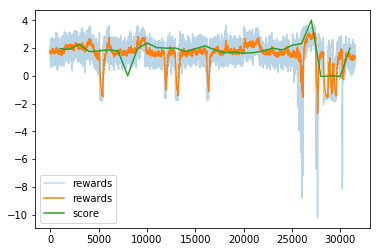

Episode: 1000, Recent reward average: 1.37 steps average: 77.36, eps:0.100 score:2.360
Episode: 2000, Recent reward average: -1.37 steps average: 236.47, eps:0.100 score:-0.048
Episode: 3000, Recent reward average: -1.44 steps average: 239.27, eps:0.100 score:4.000
Episode: 4000, Recent reward average: 2.33 steps average: 61.50, eps:0.100 score:4.000
Episode: 5000, Recent reward average: 2.13 steps average: 64.00, eps:0.100 score:2.114
Episode: 6000, Recent reward average: 1.71 steps average: 62.51, eps:0.100 score:1.909
Episode: 7000, Recent reward average: 0.36 steps average: 139.01, eps:0.100 score:0.000

55: 3K


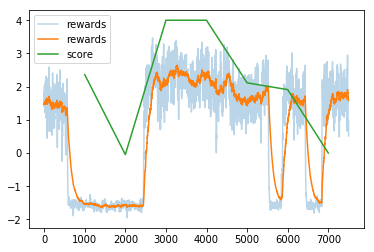

Episode: 1000, Recent reward average: 1.58 steps average: 68.03, eps:0.100 score:1.868
Episode: 2000, Recent reward average: 1.49 steps average: 70.18, eps:0.100 score:2.196
Episode: 3000, Recent reward average: 1.71 steps average: 72.20, eps:0.100 score:1.868
Episode: 4000, Recent reward average: 1.49 steps average: 85.23, eps:0.100 score:2.073
Episode: 5000, Recent reward average: 1.12 steps average: 98.88, eps:0.100 score:1.704
Episode: 6000, Recent reward average: 1.61 steps average: 67.37, eps:0.100 score:1.991
Episode: 7000, Recent reward average: 1.99 steps average: 69.27, eps:0.100 score:2.000
Episode: 8000, Recent reward average: 1.52 steps average: 68.27, eps:0.100 score:1.950
Episode: 9000, Recent reward average: 1.50 steps average: 70.57, eps:0.100 score:1.950
.Episode: 10000, Recent reward average: 1.60 steps average: 70.24, eps:0.100 score:2.032
Episode: 11000, Recent reward average: 1.63 steps average: 67.68, eps:0.100 score:1.540
Episode: 12000, Recent reward average: 0

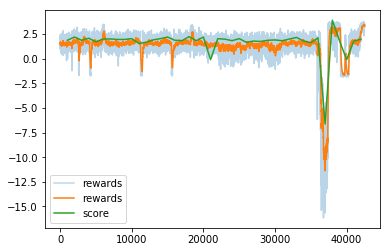

Episode: 1000, Recent reward average: 2.39 steps average: 75.49, eps:0.100 score:1.745
Episode: 2000, Recent reward average: 1.62 steps average: 74.93, eps:0.100 score:2.155
Episode: 3000, Recent reward average: 1.55 steps average: 74.25, eps:0.100 score:2.442
Episode: 4000, Recent reward average: 1.62 steps average: 73.71, eps:0.100 score:2.237
Episode: 5000, Recent reward average: 1.57 steps average: 73.32, eps:0.100 score:1.909
Episode: 6000, Recent reward average: 1.43 steps average: 72.72, eps:0.100 score:2.360
Episode: 7000, Recent reward average: 1.48 steps average: 72.82, eps:0.100 score:1.868
Episode: 8000, Recent reward average: 1.59 steps average: 72.77, eps:0.100 score:1.581
Episode: 9000, Recent reward average: 1.54 steps average: 73.10, eps:0.100 score:2.026
.Episode: 10000, Recent reward average: -0.64 steps average: 186.73, eps:0.100 score:-0.100
Episode: 11000, Recent reward average: -1.41 steps average: 235.17, eps:0.100 score:-0.151
Episode: 12000, Recent reward aver

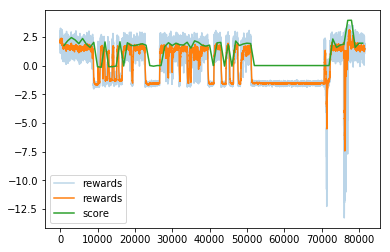

Episode: 1000, Recent reward average: 1.62 steps average: 78.68, eps:0.100 score:1.909
Episode: 2000, Recent reward average: 1.59 steps average: 79.29, eps:0.100 score:1.581
Episode: 3000, Recent reward average: 1.53 steps average: 79.30, eps:0.100 score:2.196
Episode: 4000, Recent reward average: 1.66 steps average: 78.88, eps:0.100 score:1.950
Episode: 5000, Recent reward average: 1.57 steps average: 81.15, eps:0.100 score:2.155
Episode: 6000, Recent reward average: 1.49 steps average: 79.03, eps:0.100 score:1.827
Episode: 7000, Recent reward average: 1.67 steps average: 79.23, eps:0.100 score:1.868
Episode: 8000, Recent reward average: 1.54 steps average: 80.39, eps:0.100 score:2.237
Episode: 9000, Recent reward average: 1.57 steps average: 79.69, eps:0.100 score:1.663
.Episode: 10000, Recent reward average: 1.58 steps average: 78.81, eps:0.100 score:1.909
Episode: 11000, Recent reward average: 1.57 steps average: 79.33, eps:0.100 score:1.868
Episode: 12000, Recent reward average: 1

Episode: 95000, Recent reward average: 1.44 steps average: 83.09, eps:0.100 score:1.950
Episode: 96000, Recent reward average: 1.42 steps average: 86.00, eps:0.100 score:1.704
Episode: 97000, Recent reward average: 1.49 steps average: 87.41, eps:0.100 score:2.114
Episode: 98000, Recent reward average: 1.59 steps average: 84.17, eps:0.100 score:1.991
Episode: 99000, Recent reward average: 1.27 steps average: 92.88, eps:0.100 score:2.073
.Episode: 100000, Recent reward average: 1.50 steps average: 88.20, eps:0.100 score:1.991
Episode: 101000, Recent reward average: 1.29 steps average: 95.08, eps:0.100 score:1.704
Episode: 102000, Recent reward average: 1.40 steps average: 92.39, eps:0.100 score:1.950
Episode: 103000, Recent reward average: 1.40 steps average: 90.95, eps:0.100 score:1.991
Episode: 104000, Recent reward average: 1.33 steps average: 90.84, eps:0.100 score:1.950
Episode: 105000, Recent reward average: 1.45 steps average: 86.47, eps:0.100 score:0.000
Episode: 106000, Recent r

Episode: 187000, Recent reward average: -1.54 steps average: 249.00, eps:0.100 score:0.000
Episode: 188000, Recent reward average: -1.53 steps average: 249.00, eps:0.100 score:0.000
Episode: 189000, Recent reward average: -1.54 steps average: 249.00, eps:0.100 score:0.000
.Episode: 190000, Recent reward average: 1.24 steps average: 100.21, eps:0.100 score:2.073
Episode: 191000, Recent reward average: 1.16 steps average: 100.53, eps:0.100 score:1.991
Episode: 192000, Recent reward average: 1.13 steps average: 102.72, eps:0.100 score:0.000
Episode: 193000, Recent reward average: -1.42 steps average: 249.00, eps:0.100 score:0.000
Episode: 194000, Recent reward average: -1.25 steps average: 235.19, eps:0.100 score:0.000
Episode: 195000, Recent reward average: 0.13 steps average: 154.78, eps:0.100 score:0.000
Episode: 196000, Recent reward average: -0.43 steps average: 186.54, eps:0.100 score:0.000
Episode: 197000, Recent reward average: 1.25 steps average: 97.02, eps:0.100 score:1.991
Epis

Episode: 278000, Recent reward average: -0.01 steps average: 165.39, eps:0.100 score:0.000
Episode: 279000, Recent reward average: -1.38 steps average: 237.73, eps:0.100 score:0.000
.Episode: 280000, Recent reward average: 0.09 steps average: 161.12, eps:0.100 score:0.000
Episode: 281000, Recent reward average: 0.67 steps average: 127.34, eps:0.100 score:2.114
Episode: 282000, Recent reward average: 1.20 steps average: 100.51, eps:0.100 score:1.745
Episode: 283000, Recent reward average: 0.42 steps average: 141.51, eps:0.100 score:0.000
Episode: 284000, Recent reward average: -1.47 steps average: 249.00, eps:0.100 score:0.000
Episode: 285000, Recent reward average: 0.32 steps average: 147.78, eps:0.100 score:1.868
Episode: 286000, Recent reward average: 1.23 steps average: 104.51, eps:0.100 score:1.786
Episode: 287000, Recent reward average: -0.40 steps average: 190.87, eps:0.100 score:0.000
Episode: 288000, Recent reward average: 0.90 steps average: 115.78, eps:0.100 score:1.704
Episo

KeyboardInterrupt: 

In [26]:
generateResults(0,70,originalAgent=False)

Episode: 1000, Recent reward average: 2.12 steps average: 0.20, eps:0.100 score:1.950
Episode: 2000, Recent reward average: 1.97 steps average: 0.34, eps:0.100 score:1.786
Episode: 3000, Recent reward average: 2.06 steps average: 0.56, eps:0.100 score:1.868
Episode: 4000, Recent reward average: 2.12 steps average: 0.28, eps:0.100 score:1.786
Episode: 5000, Recent reward average: 3.22 steps average: 0.04, eps:0.100 score:4.000
Episode: 6000, Recent reward average: 3.88 steps average: 0.05, eps:0.100 score:4.000
Episode: 7000, Recent reward average: 3.86 steps average: 0.04, eps:0.100 score:4.000
Episode: 8000, Recent reward average: 3.87 steps average: 0.05, eps:0.100 score:4.000
Episode: 9000, Recent reward average: 3.87 steps average: 0.06, eps:0.100 score:4.000

0: 5K


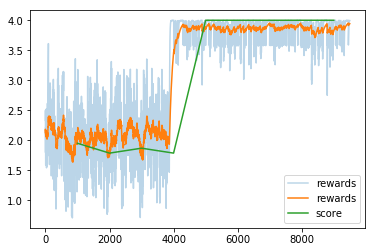

Episode: 1000, Recent reward average: -14.09 steps average: 249.00, eps:0.100 score:-13.611
Episode: 2000, Recent reward average: -8.90 steps average: 164.99, eps:0.100 score:-25.000
Episode: 3000, Recent reward average: -2.33 steps average: 47.72, eps:0.100 score:-25.000
Episode: 4000, Recent reward average: -1.98 steps average: 44.54, eps:0.100 score:-25.000
Episode: 5000, Recent reward average: -2.22 steps average: 46.94, eps:0.100 score:-25.000
Episode: 6000, Recent reward average: -2.57 steps average: 50.43, eps:0.100 score:-25.000
Episode: 7000, Recent reward average: -2.54 steps average: 49.35, eps:0.100 score:-25.000
Episode: 8000, Recent reward average: -2.13 steps average: 45.10, eps:0.100 score:-25.000
Episode: 9000, Recent reward average: -2.44 steps average: 47.97, eps:0.100 score:-25.000
.Episode: 10000, Recent reward average: -2.35 steps average: 46.98, eps:0.100 score:-25.000
Episode: 11000, Recent reward average: -2.21 steps average: 45.80, eps:0.100 score:-25.000
Epis

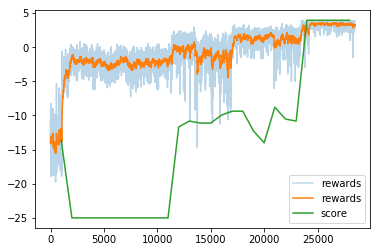

Episode: 1000, Recent reward average: 3.23 steps average: 12.73, eps:0.100 score:3.900
Episode: 2000, Recent reward average: 3.38 steps average: 12.01, eps:0.100 score:3.900
Episode: 3000, Recent reward average: 3.42 steps average: 11.70, eps:0.100 score:3.900
Episode: 4000, Recent reward average: -0.54 steps average: 38.82, eps:0.100 score:1.973
Episode: 5000, Recent reward average: 1.67 steps average: 13.25, eps:0.100 score:1.891

10: 1K


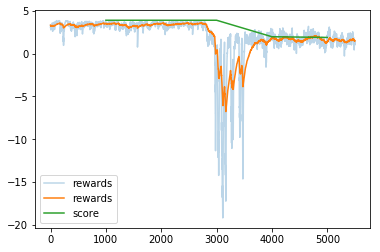

Episode: 1000, Recent reward average: 1.52 steps average: 18.47, eps:0.100 score:1.964
Episode: 2000, Recent reward average: 1.64 steps average: 17.88, eps:0.100 score:1.841
Episode: 3000, Recent reward average: 1.59 steps average: 17.24, eps:0.100 score:1.513
Episode: 4000, Recent reward average: 1.58 steps average: 17.61, eps:0.100 score:1.554
Episode: 5000, Recent reward average: 1.62 steps average: 18.19, eps:0.100 score:1.923
Episode: 6000, Recent reward average: 1.54 steps average: 18.33, eps:0.100 score:1.841
Episode: 7000, Recent reward average: 1.67 steps average: 17.89, eps:0.100 score:1.472
Episode: 8000, Recent reward average: 1.57 steps average: 17.31, eps:0.100 score:1.923
Episode: 9000, Recent reward average: 1.59 steps average: 17.47, eps:0.100 score:1.636
.Episode: 10000, Recent reward average: 1.66 steps average: 17.59, eps:0.100 score:1.349
Episode: 11000, Recent reward average: 1.59 steps average: 17.24, eps:0.100 score:1.964
Episode: 12000, Recent reward average: 1

Episode: 95000, Recent reward average: 1.68 steps average: 17.23, eps:0.100 score:1.636
Episode: 96000, Recent reward average: 1.70 steps average: 17.43, eps:0.100 score:1.882
Episode: 97000, Recent reward average: 1.59 steps average: 18.00, eps:0.100 score:1.554
Episode: 98000, Recent reward average: 1.54 steps average: 17.88, eps:0.100 score:1.510
Episode: 99000, Recent reward average: 1.63 steps average: 17.85, eps:0.100 score:1.882
.Episode: 100000, Recent reward average: 1.59 steps average: 17.90, eps:0.100 score:1.554
Episode: 101000, Recent reward average: 1.76 steps average: 17.86, eps:0.100 score:1.923
Episode: 102000, Recent reward average: 1.55 steps average: 17.58, eps:0.100 score:1.670
Episode: 103000, Recent reward average: 1.52 steps average: 17.43, eps:0.100 score:1.964
Episode: 104000, Recent reward average: 1.66 steps average: 17.45, eps:0.100 score:1.185
Episode: 105000, Recent reward average: 1.63 steps average: 17.62, eps:0.100 score:1.759
Episode: 106000, Recent r

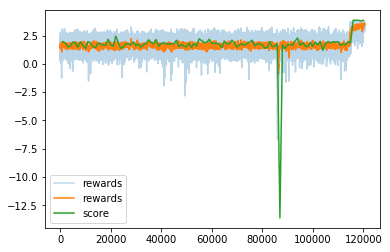

Episode: 1000, Recent reward average: 3.31 steps average: 22.88, eps:0.100 score:3.747
Episode: 2000, Recent reward average: 3.28 steps average: 22.89, eps:0.100 score:3.800
Episode: 3000, Recent reward average: 3.30 steps average: 22.93, eps:0.100 score:3.800
Episode: 4000, Recent reward average: 3.36 steps average: 22.61, eps:0.100 score:3.800
Episode: 5000, Recent reward average: 3.34 steps average: 22.87, eps:0.100 score:3.742

20: 1K


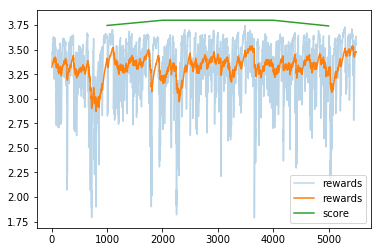

Episode: 1000, Recent reward average: 3.23 steps average: 28.41, eps:0.100 score:3.704
Episode: 2000, Recent reward average: 3.24 steps average: 28.62, eps:0.100 score:3.750
Episode: 3000, Recent reward average: 3.33 steps average: 28.64, eps:0.100 score:3.750
Episode: 4000, Recent reward average: 3.28 steps average: 28.58, eps:0.100 score:3.691
Episode: 5000, Recent reward average: 3.32 steps average: 28.54, eps:0.100 score:3.690

25: 1K


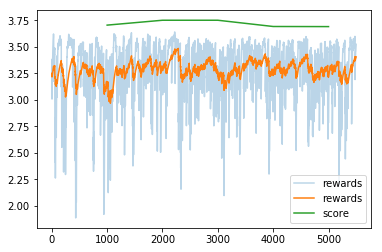

Episode: 1000, Recent reward average: 3.19 steps average: 33.62, eps:0.100 score:3.650
Episode: 2000, Recent reward average: 3.29 steps average: 34.14, eps:0.100 score:3.651
Episode: 3000, Recent reward average: 3.19 steps average: 34.13, eps:0.100 score:3.647
Episode: 4000, Recent reward average: 3.21 steps average: 34.19, eps:0.100 score:3.652
Episode: 5000, Recent reward average: 3.26 steps average: 34.41, eps:0.100 score:3.700

30: 1K


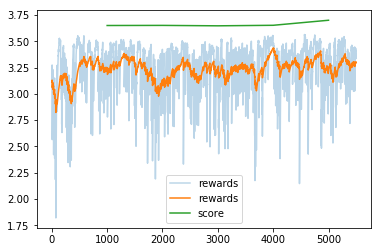

Episode: 1000, Recent reward average: 3.18 steps average: 39.84, eps:0.100 score:3.650
Episode: 2000, Recent reward average: 3.14 steps average: 39.83, eps:0.100 score:3.592
Episode: 3000, Recent reward average: 3.09 steps average: 40.57, eps:0.100 score:3.606
Episode: 4000, Recent reward average: 3.09 steps average: 40.40, eps:0.100 score:3.606
Episode: 5000, Recent reward average: 3.18 steps average: 40.12, eps:0.100 score:3.602

35: 1K


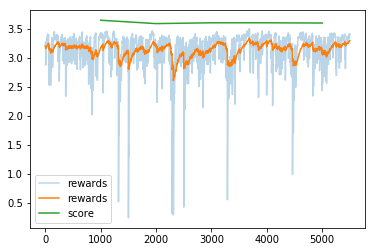

Episode: 1000, Recent reward average: 3.08 steps average: 45.63, eps:0.100 score:3.558
Episode: 2000, Recent reward average: 3.05 steps average: 46.08, eps:0.100 score:3.600
Episode: 3000, Recent reward average: 3.06 steps average: 46.01, eps:0.100 score:3.600
Episode: 4000, Recent reward average: 2.68 steps average: 48.86, eps:0.100 score:3.551
Episode: 5000, Recent reward average: 2.83 steps average: 47.43, eps:0.100 score:3.600

40: 1K


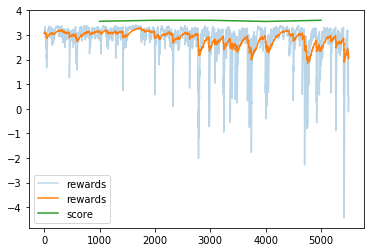

Episode: 1000, Recent reward average: 2.73 steps average: 53.45, eps:0.100 score:3.550
Episode: 2000, Recent reward average: 3.01 steps average: 50.97, eps:0.100 score:3.446
Episode: 3000, Recent reward average: 2.84 steps average: 52.62, eps:0.100 score:3.550
Episode: 4000, Recent reward average: 2.73 steps average: 53.14, eps:0.100 score:3.550
Episode: 5000, Recent reward average: 2.84 steps average: 53.17, eps:0.100 score:3.550

45: 1K


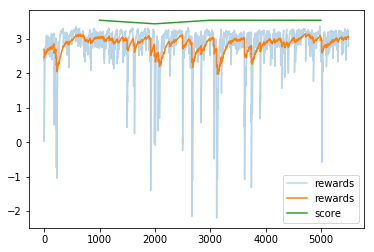

Episode: 1000, Recent reward average: 2.78 steps average: 58.48, eps:0.100 score:3.500
Episode: 2000, Recent reward average: 2.78 steps average: 58.66, eps:0.100 score:3.457
Episode: 3000, Recent reward average: 2.66 steps average: 59.26, eps:0.100 score:3.408
Episode: 4000, Recent reward average: 2.84 steps average: 58.81, eps:0.100 score:3.500
Episode: 5000, Recent reward average: 2.84 steps average: 58.08, eps:0.100 score:3.500

50: 1K


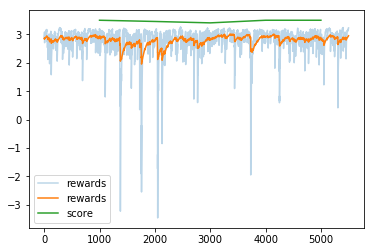

Episode: 1000, Recent reward average: 2.68 steps average: 66.47, eps:0.100 score:3.450
Episode: 2000, Recent reward average: 2.75 steps average: 63.88, eps:0.100 score:3.358
Episode: 3000, Recent reward average: 2.44 steps average: 67.83, eps:0.100 score:3.450
Episode: 4000, Recent reward average: 2.57 steps average: 69.30, eps:0.100 score:3.318
Episode: 5000, Recent reward average: 2.63 steps average: 67.69, eps:0.100 score:3.450

55: 1K


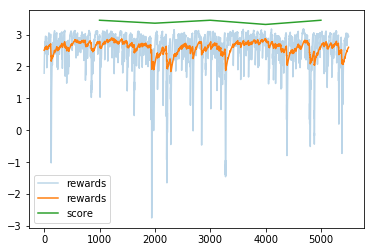

Episode: 1000, Recent reward average: 2.05 steps average: 78.23, eps:0.100 score:3.221
Episode: 2000, Recent reward average: 2.38 steps average: 77.06, eps:0.100 score:3.400
Episode: 3000, Recent reward average: 2.44 steps average: 75.46, eps:0.100 score:3.281
Episode: 4000, Recent reward average: 2.38 steps average: 77.70, eps:0.100 score:3.400
Episode: 5000, Recent reward average: 2.49 steps average: 75.86, eps:0.100 score:3.346
Episode: 6000, Recent reward average: 2.17 steps average: 83.33, eps:0.100 score:3.400

60: 2K


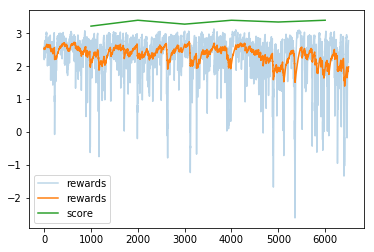

Episode: 1000, Recent reward average: 1.65 steps average: 99.54, eps:0.100 score:0.538
Episode: 2000, Recent reward average: 1.37 steps average: 107.67, eps:0.100 score:3.350
Episode: 3000, Recent reward average: 1.35 steps average: 104.73, eps:0.100 score:0.275
Episode: 4000, Recent reward average: 0.70 steps average: 126.65, eps:0.100 score:0.375
Episode: 5000, Recent reward average: 0.13 steps average: 129.81, eps:0.100 score:0.261
Episode: 6000, Recent reward average: 1.03 steps average: 120.87, eps:0.100 score:0.229

65: 2K


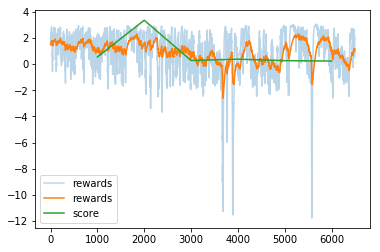

Episode: 1000, Recent reward average: 0.25 steps average: 144.75, eps:0.100 score:3.300
Episode: 2000, Recent reward average: 0.26 steps average: 133.18, eps:0.100 score:3.300
Episode: 3000, Recent reward average: 1.36 steps average: 112.45, eps:0.100 score:0.342
Episode: 4000, Recent reward average: 2.13 steps average: 97.47, eps:0.100 score:3.300
Episode: 5000, Recent reward average: 1.69 steps average: 105.29, eps:0.100 score:3.300

70: 1K


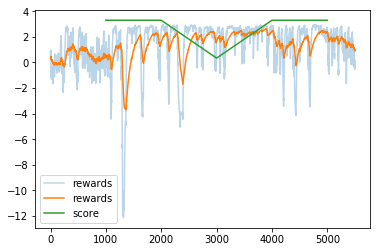

In [27]:
generateResults(0,70,step_reward=-0.01, originalAgent=False)

In [19]:
def print_lstm(agent):
    # memory state
    print(np.array(agent.h_state.detach()), np.array(agent.c_state.detach()))
    
#print_lstm(agent)

In [21]:
# test agent
#print(agent.epsilon)
#env = TMaze(6)
#eval_agent(agent=agent, env=env, trials=1, verbose=True, use_egreedy=True)

In [22]:
print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f}".format(
                    i, 
                    np.mean(totalRewards[-1000:]),
                    np.mean(totalSteps[-1000:]),
                    EPSILON))


Episode: 99, Recent reward average: 3.85 steps average: 0.06, eps:0.100


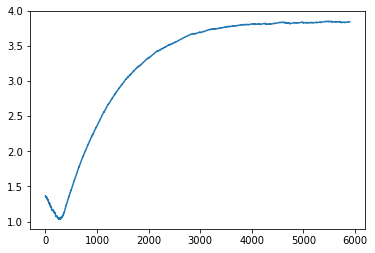

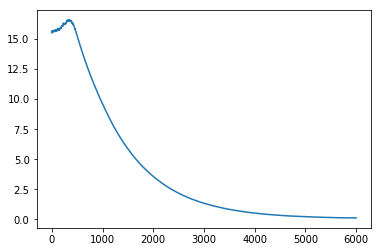

In [23]:
def smooth(X, gamma = 0.9):
    """ Returns exponential moving average. """
    y = np.mean(X[:500])
    out = []
    for x in X:
        y = gamma * y + (1-gamma) * x
        out.append(y)
    return out

plt.plot(range(len(totalRewards[100:])), smooth(totalRewards[100:],0.999), label = "rewards")
plt.show()
plt.plot(range(len(totalSteps)), smooth(totalSteps, 0.999), label = 'steps')
plt.show()

Yo/
